# A notebook to carry out calculations

In [1]:
import sympy as sym
import scipy as sp
import numpy as np
sym.init_printing()

import imp
tools = imp.load_source('tools', '../tools.py')

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"
assert np.__version__ == "1.12.1"

In [2]:
#import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
from scipy.optimize import brentq

Defining all our variables (with assumption that they are positive).

In [3]:
r, s, x, theta_r, alpha, H, beta, gamma, F = sym.symbols("r, s, x, theta_r, alpha, \
                                                          H, beta, gamma, F", positive=True)

The functions:

In [4]:
tools.theta(r, s)

In [5]:
tools.psi(r, s)

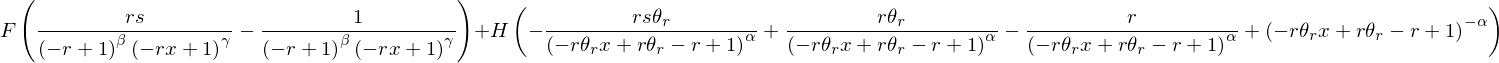

In [6]:
# the utility
tools.utility(s, x).expand().collect(F).collect(H).collect(r)

# Condition for $s=1$ to be stable:

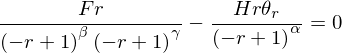

In [7]:
expr = tools.utility(1, 1) - tools.utility(0, 1)
stable_selective_condition = sym.Eq(expr.expand(), 0)
stable_selective_condition

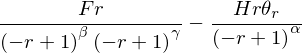

In [8]:
expr.simplify()

In [9]:
(expr.simplify().collect(r) / r).subs({r:0})

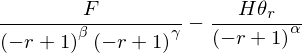

In [10]:
(expr.simplify().collect(r) / r)

In [11]:
(expr.simplify().collect(r) / r).subs({r:0})

numerical example
-------------------

In [12]:
# some values for the parameters
gamma_num = 1
beta_num = .95
alpha_num = .95 
theta_r_num = .2  # Quantity of horn in devalued Rhino
F_num = 10
a1_num = 7
H_num = 100

In [13]:
variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, 
             theta_r:theta_r_num, F: F_num, H: H_num, r:.97}

In [14]:
strategies = np.linspace(0, 0.99, 100)

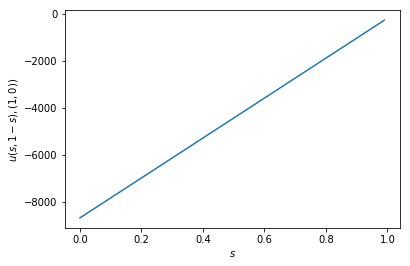

In [15]:
utilities = [tools.utility(s, 1).subs(variables) for s in strategies]

plt.plot(strategies, utilities)

plt.xlabel("$s$"); plt.ylabel("$u(s, 1-s), (1, 0))$")
plt.show()

$s = 1$ is stable as $s=1$ has the highest utility in the population.

# Condition for $s=0$ to be stable:

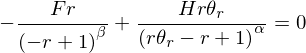

In [16]:
expr = tools.utility(0, 0) - tools.utility(1, 0)
stable_indiscrimate_condition = sym.Eq(expr.expand(), 0)
stable_indiscrimate_condition

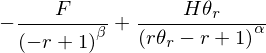

In [17]:
(expr.simplify().collect(r) / r)

In [18]:
(expr.simplify().collect(r) / r).subs({r:0})

Limit behaviour as $r\to 1$:

In [19]:
sym.limit(expr, r, 1)

# numerical example

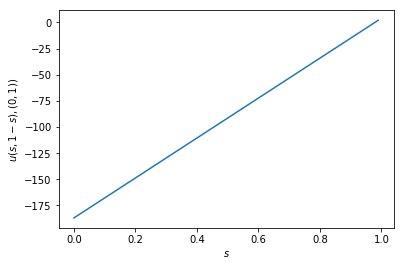

In [20]:
utilities = [tools.utility(s, 0).subs(variables) for s in strategies]

plt.plot(strategies, utilities)

plt.xlabel("$s$"); plt.ylabel("$u(s, 1-s), (0, 1))$")
plt.show()

$s = 0$ is not stable as $s=1$ has the highest utility in the population.

# Condition for $1>s^*>0$ to be stable:

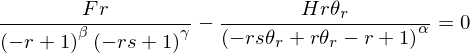

In [21]:
expr = tools.utility(1, s) - tools.utility(0, s)
stable_mixed_condition = sym.Eq(expr.simplify(), 0)
stable_mixed_condition

In preparation for numerical solution: let's see what the derivaties of the lhs of that are:

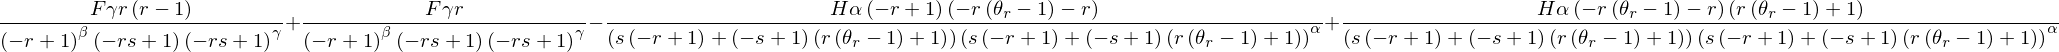

In [22]:
sym.diff(expr, s)

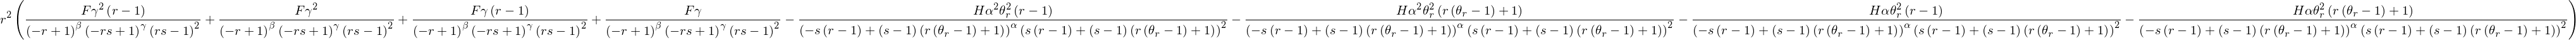

In [23]:
sym.diff(expr, s, 2)

# numerical example

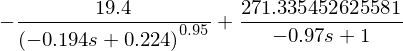

In [24]:
condition = stable_mixed_condition.lhs.subs(variables)
condition

In [25]:
conds = [condition.subs({s:s_val}) for s_val in strategies]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

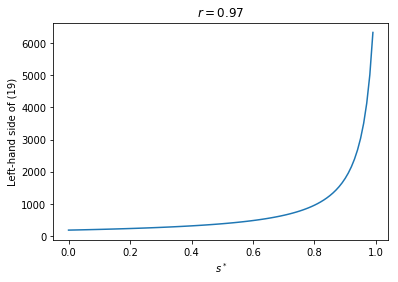

In [26]:
plt.plot(strategies, conds);
plt.title("$r=0.97$")
plt.ylabel("Left-hand side of (19)")
plt.xlabel("$s^*$")
plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

In [31]:
def s_star_v_r(r_val, gamma_num=gamma_num, beta_num=beta_num, 
               alpha_num=alpha_num, theta_r_num=theta_r_num, 
               F_num=F_num, H_num=H_num,
               stable_mixed_condition=stable_mixed_condition):
    """
    Numerically solve the condition for mixed 
    strategy stability for a given value of r.
    """
    variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, theta_r:theta_r_num, 
                 F: F_num, H: H_num, r:r_val}
    condition = stable_mixed_condition.lhs.subs(variables)
    func = lambda x: condition.subs({s: x})

    try:
        return brentq(func, a=0, b=1)
    except ValueError:
        return float("nan")

In [34]:
rs = np.linspace(0.0, .999, 1000)
s_stars = [s_star_v_r(r) for r in rs]

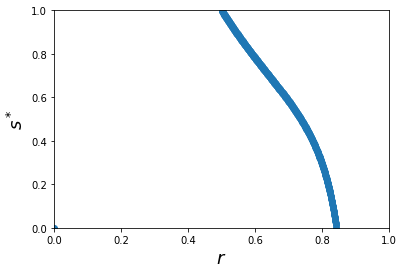

In [39]:
plt.scatter(rs, s_stars)
plt.xlabel("$r$", fontsize=18)
plt.ylabel("$s^*$", fontsize=18)
plt.ylim(0, 1);
plt.xlim(0, 1);
plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

# Evolutionary stability

Here we test the evolutionary stability of the strategies. Let the strategy we know is stable and testing
it's evolytionary stability be $s^*$. For a strategy $s^*$ to be stable, it must be the best response in a mutated population. Let the mutation population be $s = s^* \pm \epsilon$.

$s^*$ will be evolytionary stable if and only if:

$$u((s^*, 1 - s^*), (s, 1 -s)) > u((s, 1 - s), (s, 1 -s))$$

let:

$$ \delta_{\pm} = u((s^*, 1 - s^*), (s, 1 -s)) - u((s, 1 - s), (s, 1 -s))$$

In [84]:
def evolutionary_stability(s, r_val=0.97, gamma_num=gamma_num, beta_num=beta_num, 
                           alpha_num=alpha_num, theta_r_num=theta_r_num, 
                           F_num=F_num, H_num=H_num, condition=condition,
                           tol=0.000001, step=0.0000001):

    e = tol * 10
    while e > tol:
        
        variables = {gamma: gamma_num, beta: beta_num, alpha: alpha_num, theta_r:theta_r_num, 
                 F: F_num, H: H_num, r:r_val}

        delta_plus = (tools.utility(s, s + e) - tools.utility(s + e, s + e)).subs(variables)
        delta_minus = (tools.utility(s, s - e) - tools.utility(s - e, s + e)).subs(variables)
        
        if delta_plus > tol or delta_minus > tol:
            return print("Not evolutionary stable for $\epsilo=${}".format(e)) 

        e -= step 
    return print("Evolunationary stable")

In [85]:
evolutionary_stability(1)

Not evolutionary stable for $\epsilo=$9.999999999999999e-06
